### Практическое задание к курсу:
1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.


2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

### Генерация фэйковых лиц при помощи GAN.

In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [2]:
# организуем файлы в правильной последотельности
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# определяем размер изображения
SIZE = 128
_img = []
path = 'faces/'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed3000.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # преобразуем изображения в RGB формат
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # изменяем размер
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

 30%|███████████████████████                                                      | 3000/10000 [01:30<03:31, 33.13it/s]


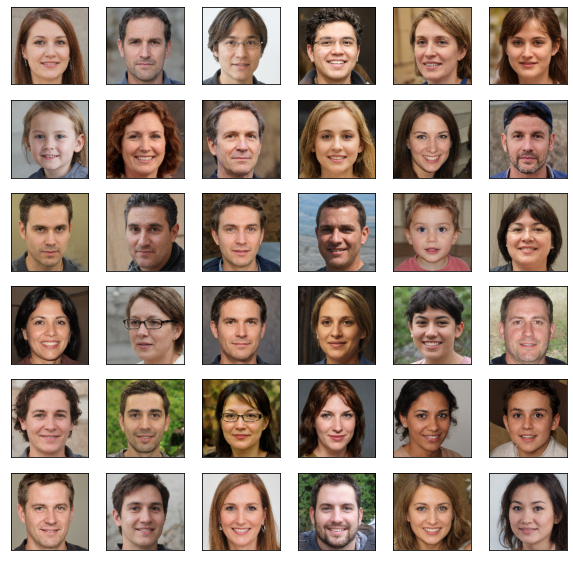

In [3]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

plot_images(6)

In [4]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

#### Генератор

Ниже приведён код генератора. В качестве вводных данных берётся случайный вектор из нормального распределения. Этот случайный вектор проходит через плотный слой, видоизменяется и подаётся на сверточные слои. После серии сверточных слоёв и нормализации вектор подаётся на Conv2DTranspose где происходит увеличение дискретезации.

В итоге на выходе генератора формируется изображение формата 128, 128, 3. В последнем слое используется в качестве активации hyperbolic tangent чтобы поместить выходные значение в диапазон от -1 до 1. Т.о. геенератор в данном случае это по сути  обычный энкодер с входными данными с низкой дискретизацией и высокой дискретизацией на выходе (upsampled). 

In [5]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
        
    return model

In [6]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                        

#### Дискриминатор

На вход дискриминатора поступает сгенерированное или реальное изображение формата 128, 128, 3. Это изображение обробатывается в сверточном слое и подаётся на одиночный нейрон где может быть определенно является ли оно настоящим или сгенерированным. Активационной функцией последнего слоя является сигмоид, поэтому выходные значения лежат в диапазоне от 0 до 1. Всё что выше 0.5 - реальная картинка, ниже 0,5 - сгенерированная. Затем этот сигнал подаётся на вход генератора для обучения.

In [7]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    
    return model

In [8]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)      

Выведем картинку генерируемую генераторм до обучения (случайный вектор из нормального распределения).

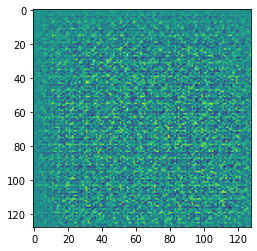

In [9]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

Определим функцию потерь и оптимайзер.

In [10]:
optimizer = tf.keras.optimizers.RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

Определим шаги обучения нейросети.

In [12]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

Напишем функцию для вывода сгенерированных изображений.

In [13]:
def plot_generated_images(square = 5, epochs = 0):
        
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [14]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

##### Обучение

In [15]:
train(7,dataset)


Epoch : 1
 Time:4494.0
Generator Loss: 0.7403934597969055 Discriminator Loss: 1.060585856437683

Epoch : 2
 Time:4350.0
Generator Loss: 1.56056809425354 Discriminator Loss: 0.9319287538528442

Epoch : 3
 Time:4356.0
Generator Loss: 1.5482280254364014 Discriminator Loss: 0.5553151965141296

Epoch : 4
 Time:4364.0
Generator Loss: 0.17859838902950287 Discriminator Loss: 2.1019880771636963

Epoch : 5
 Time:4353.0
Generator Loss: 1.0145121812820435 Discriminator Loss: 1.2682325839996338

Epoch : 6
 Time:4356.0
Generator Loss: 0.9966245889663696 Discriminator Loss: 1.2999446392059326

Epoch : 7
 Time:4354.0
Generator Loss: 1.0158460140228271 Discriminator Loss: 1.4159817695617676


Нарисуем несколько сгенерированных изображений.

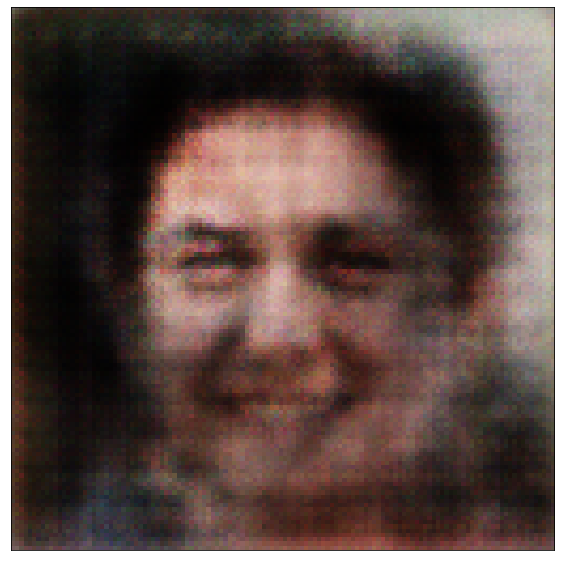

In [16]:
plot_generated_images(1)

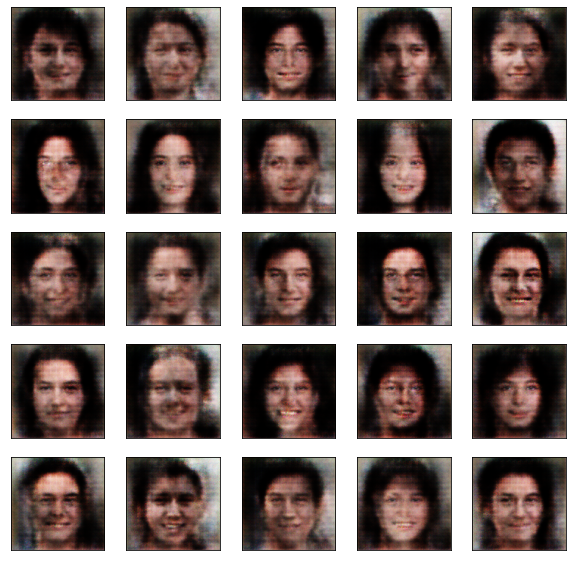

In [17]:
plot_generated_images(5)

#### Вывод:

Датасет содержит 10000 изображений человеческих лиц. Если использовать их все то процесс превращается практический в бесконечный. Я попробовал сначала 50 лиц и 5 эпох, ны выходе что-то различить было невозможно. При 1000 лиц и 5 эпохах уже были видны фэйковые лица.

Данный результат получен при 3000 изображений и 7 эпохах. Таким образом можно уверено утверждать, что основные параметры влияющие на точность данной нейросети это:
- количество изображений в датасете;
- число эпох.

Основной недостаток этой сети это её очень медленная работа.

### 2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

#### Deep Q Network (DQN)

Об успехах Google Deepmind сейчас знают и говорят. Алгоритмы DQN (Deep Q-Network) побеждают Человека с неплохим отрывом всё в большее количество игр. Достижения последних лет впечатляют: буквально за десятки минут обучения, алгоритмы учатся выигрывать человека в понг и другие игры Atari. Недавно вышли в третье измерение — побеждают человека в DOOM в реальном времени, а также учатся управлять машинами и вертолетами.

Алгоритм DQN (Deep Q-Network) algorithm впервые появился в 2015г. Он позволил добиться столь впечатляющих успехов путем сочетания  Reinforcement learning (RL)  с нейронными сетями глубокого обучения. 

DQN и Qleanring - аналогичные алгоритмы, основанные на итерации значения, но в обычном Q-обучении, когда состояние и пространство действия дискретны, а размерность невелика, Q-таблица может использоваться для хранения значения Q каждой пары действий состояния, и когда состояние и пространство действия непрерывны в высоком измерении, очень трудно использовать Q-таблицу без слишком большого пространства действия и состояния. Однако, можно перевести обновление Q-таблицы в проблему подбора функций, подгоняя функцию вместо Q-таблицы для генерации значений Q. В результате чего, похожие состояния будут вызывать похожие выходные действия.

Таким образом, глубокая нейронная сеть хорошо влияет на извлечение сложных функций. Такое влияние даёт возможность комбинировать DeepLearning (DL) и Reinforcement Learning (RL).


#### Комбинация DL и RL имеет следующие проблемы:

- Шум и задержка, в связи с этим во многих состояниях значения вознаграждения состояния равны 0, что является редкими выборками.
- Каждый образец DL не зависит друг от друга, и значение текущего состояния RL зависит от возвращаемого значения последнего состояния.
- При использовании нелинейной сети для представления функции значения, может возникнуть нестабильность

Два основных инструмента в DQN решают вышеуказанные проблемы

- Использование награды для создания тегов через Q-Learning
- Воспроизведение опыта (пул опыта) для решения проблемы корреляции и нестатического распределения.

Пул опыта в DQN используется для изучения предыдущего опыта, и поскольку Q обучение это метод автономного обучения то такой метод позволяет не только учиться на прошлом опыте но так же учиться без использования прошлого опыта, что уже почти фантастика. 

#### Основные преимущества Deep Q Network

- Случайное добавление предыдущего опыта в учебный процесс сделает нейронную сеть более эффективной.
- Пул опыта решает проблему релевантности и нестатического распределения.

Основной недостаток

С ростом числа циклов обучения происходит резкое увеличение потребляемых ресурсов при этом ошибка уменьшается незначительно, а в некоторых случаях может и возрастать.

В этом недостатке и заключается основная трудность в применении алгоритма на практике.